# APCEMM

Pycontrails interface for the MIT [Aircraft Plume Chemistry Emission and Microphysics Model (APCEMM)](https://github.com/MIT-LAE/APCEMM).

This interface evaluates `APCEMM` for segments of a pycontrails `Flight` trajectory.

## References

Fritz, Thibaud M., Sebatian D. Eastham, Raymond L. Speth, and Steven R.H. Barret. “The role of plume-scale processes in long-term impacts of aircraft emissions.” Atmospheric Chemistry and Physics 20, no. 9 (May 13, 2020): 5697–727. https://doi.org/10.5194/acp-20-5697-2020.

In [1]:
import os

import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import xarray as xr

from pycontrails import Flight, MetDataset
from pycontrails.datalib.ecmwf import ARCOERA5
from pycontrails.models.apcemm import APCEMM
from pycontrails.models.apcemm.inputs import APCEMMInput
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.issr import ISSR
from pycontrails.models.ps_model import PSFlight
from pycontrails.physics import thermo, units

plt.rcParams["figure.figsize"] = (10, 6)

## Download meteorology data

This demo uses model-level [ERA5](https://www.ecmwf.int/en/forecasts/dataset/ecmwf-reanalysis-v5) data from the [ARCO ERA5 dataset](https://github.com/google-research/arco-era5) for met data. 

>  Note this will download ~3 GB of meteorology data to your computer

Processing ARCO ERA5 data requires [metview](https://metview.readthedocs.io/en/latest/) binary and python bindings. If pycontrails is installed in a conda environment, metview can be installed by running
```bash
conda install -c conda-forge metview
conda install -c conda-forge metview-python
python -m metview selfcheck
```

In [2]:
time_bounds = ("2019-01-01 00:00:00", "2019-01-01 04:00:00")

In [3]:
era5ml = ARCOERA5(time=time_bounds, variables=APCEMM.met_variables, n_jobs=4)

In [4]:
met = era5ml.open_metdataset(wrap_longitude=True)

/home/ext_tristan_abbott_breakthroughe/miniconda3/envs/contrails/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### Plot RHI at FL350

In [5]:
fl350 = met.data.sel(level=units.ft_to_pl(35_000), method="nearest")

In [6]:
rhi = thermo.rhi(fl350["specific_humidity"], fl350["air_temperature"], fl350["air_pressure"])

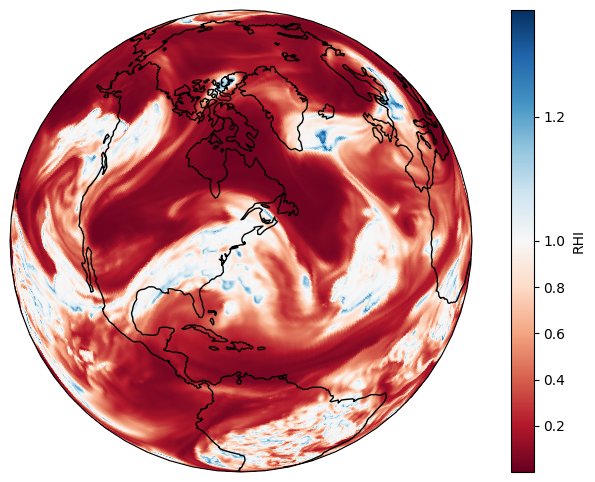

In [7]:
ax = plt.subplot(
    111, projection=ccrs.NearsidePerspective(central_longitude=-71.1, central_latitude=42.3)
)
ax.coastlines()
im = ax.pcolormesh(
    rhi["longitude"],
    rhi["latitude"],
    rhi.isel(time=0).T,
    shading="nearest",
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    norm=colors.TwoSlopeNorm(vcenter=1.0),
)
plt.colorbar(im, label="RHI");

## Load Flight Data

A `Flight` can be loaded from CSV, parquet, or created from a pandas DataFrame. Here, we create a synthetic flight between Chicago and Boston at 35,000 ft.

In [8]:
flight_attrs = {
    "flight_id": "test",
    "aircraft_type": "B738",
}

df = pd.DataFrame()
df["longitude"] = np.array([-87.6298, -71.0589])
df["latitude"] = np.array([41.8781, 42.3601])
df["altitude_ft"] = np.array([35_000.0, 35_000.0])
df["time"] = np.array([np.datetime64("2019-01-01 01:00"), np.datetime64("2019-01-01 02:15")])

flight = Flight(df, attrs=flight_attrs).resample_and_fill("1min")

## Select waypoints for evaluation with APCEMM

We use the `ISSR` model to select waypoints with varying RHi.

In [9]:
# model ISSR
model = ISSR(met, humidity_scaling=HistogramMatching(level_type="model"))
result = model.eval(flight, copy_source=True)

In [10]:
# select a few waypoints
segments = [3, 29, 38]

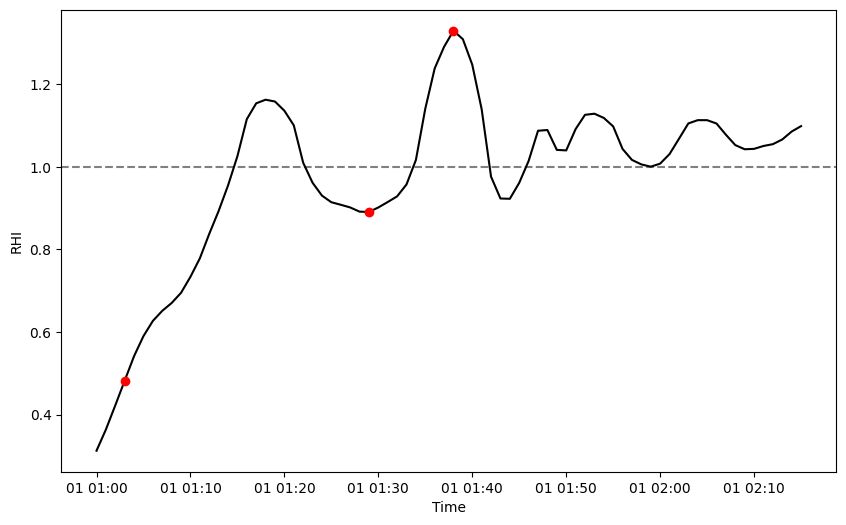

In [11]:
# plot select segments on ISSR results
plt.plot(result["time"], result["rhi"], "k-")
for segment in segments:
    plt.plot(result["time"][segment], result["rhi"][segment], "ro")
plt.xlabel("Time")
plt.ylabel("RHI")
plt.gca().axhline(y=1, color="gray", ls="--", zorder=-1);

## Run APCEMM on selected flight segments

The pycontrails interface assumes that APCEMM is installed at `$HOME/APCEMM` when generating input YAML files, but a different root directory can be used by modifying the `apcemm_root` attribute in `APCEMMYaml`.

The `max_age` parameter should be longer than 3 hour to simulate the full lifecycle of persistent contrails. We use a small value to keep the simulation runtime relatively short.

In [12]:
apcemm_root = f"{os.getenv('HOME')}/Files/Code/contrails/APCEMM"

model = APCEMM(
    apcemm_path=f"{apcemm_root}/build/APCEMM",
    apcemm_root=apcemm_root,
    met=met,
    max_age=np.timedelta64(1, "h"),
    aircraft_performance=PSFlight(),
    humidity_scaling=HistogramMatching(level_type="model"),
)

Setting `n_jobs = 3` runs simulations for all three segments in parallel.

In [13]:
result = model.eval(flight, waypoints=segments, n_jobs=3)

In [14]:
model.params["dt_lagrangian"]

numpy.timedelta64(30,'m')

## Print status of APCEMM simulations

In [15]:
for segment in segments:
    print(f"Segment {segment}: {result.dataframe.iloc[segment]['status']}")

Segment 3: NoWaterSaturation
Segment 29: NoPersistence
Segment 38: Incomplete


## Plot time series output

In [16]:
df = model.vortex
df = df[df["waypoint"] == 38].sort_values("time")

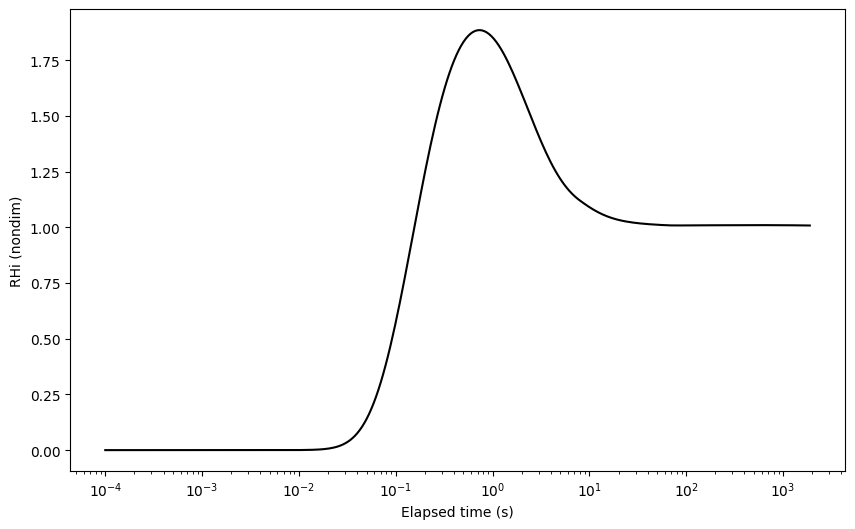

In [17]:
elapsed_time = (df["time"] - flight.dataframe.iloc[38]["time"]).dt.total_seconds()
plt.plot(elapsed_time, df["RH_i [-]"], "k-")
plt.gca().set_xscale("log")
plt.xlabel("Elapsed time (s)")
plt.ylabel("RHi (nondim)");

## Plot netCDF output

In [18]:
df = model.contrail
df = df[df["waypoint"] == 38]

In [19]:
ds = xr.open_dataset(df.iloc[-1].path, decode_times=False)

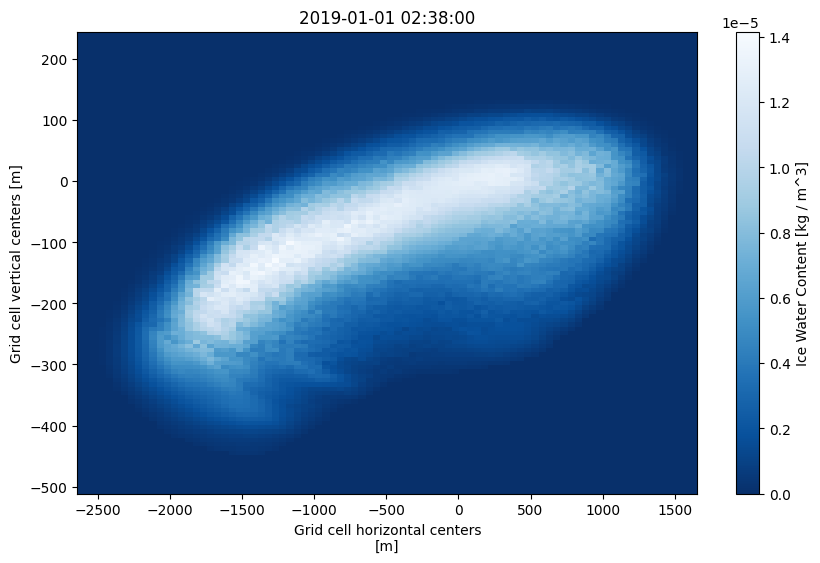

In [20]:
ds["IWC"].plot(cmap="Blues_r")
plt.title(df.iloc[-1]["time"]);

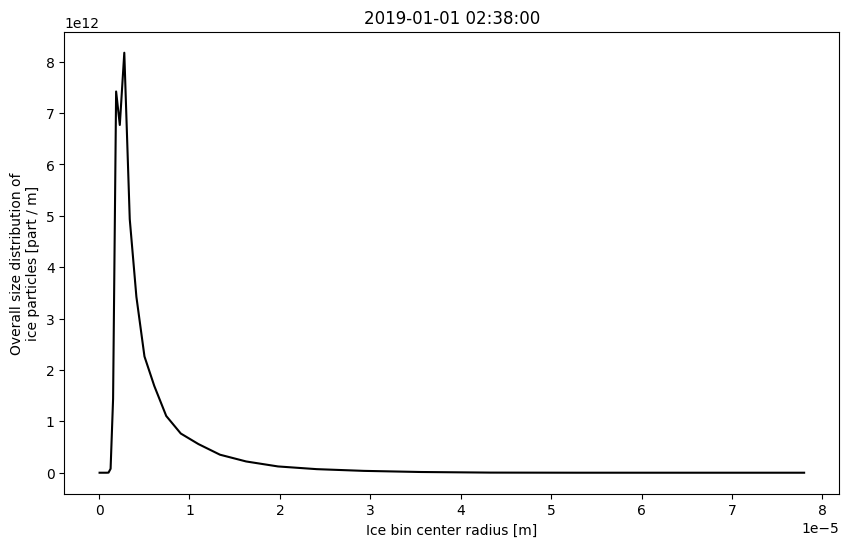

In [21]:
ds["Overall size distribution"].plot(color="k")
plt.title(df.iloc[-1]["time"]);